# GeoAI Ground-level NO2 Estimation Challenge by ITU

The data is:

1. Ground-truth data from air quality monitoring stations in the continental part of Lombardy and Veneto regions.
2. Remote sensing data of NO2 from Sentinel-5P TROPOMI, precipitation from CHIRPS and land surface temperature from NOAA datasets, all from Google Earth Engine (GEE).
3. Participants don't have to use all the parameters provided, but are encouraged to create new ones from the existing ones, which could help to improve the performance of the model.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline as IMBPipeline

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


Target: GT_NO2

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


We check for missing data first.

In [4]:
train_data.isnull().sum() / train_data.shape[0] * 100 # percentage of missing data per column

ID_Zindi               0.000000
Date                   0.000000
ID                     0.000000
LAT                    0.000000
LON                    0.000000
Precipitation          0.000000
LST                   45.950753
AAI                   14.869953
CloudFraction         14.869953
NO2_strat             14.869953
NO2_total             14.869953
NO2_trop              40.969463
TropopausePressure    14.869953
GT_NO2                 5.235378
dtype: float64

First, target column. It’s about 5% of missing data. We can just drop the missing rows, which we will do, since it’s the target, imputing the data is tricky.

In [5]:
train_data.dropna(inplace=True, subset=['GT_NO2'])
train_data.drop(['ID', 'ID_Zindi'], inplace=True, axis=1)
train_data.isnull().sum() / train_data.shape[0] * 100

Date                   0.000000
LAT                    0.000000
LON                    0.000000
Precipitation          0.000000
LST                   45.817845
AAI                   14.768863
CloudFraction         14.768863
NO2_strat             14.768863
NO2_total             14.768863
NO2_trop              40.741734
TropopausePressure    14.768863
GT_NO2                 0.000000
dtype: float64

In [6]:
def date_transformer(X):
        X = X.copy()
        date = pd.to_datetime(X['Date'])
        X['Year'] = date.dt.year
        X['Month'] = date.dt.month
        X['Day'] = date.dt.day
        X = X.drop(['Date'], axis=1)
        return X

In [7]:
train_data = date_transformer(train_data)

/var/folders/by/pqh4gvw52t5fm7pvbqnvcyy00000gn/T/ipykernel_5304/434199405.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(X['Date'])


<Axes: >

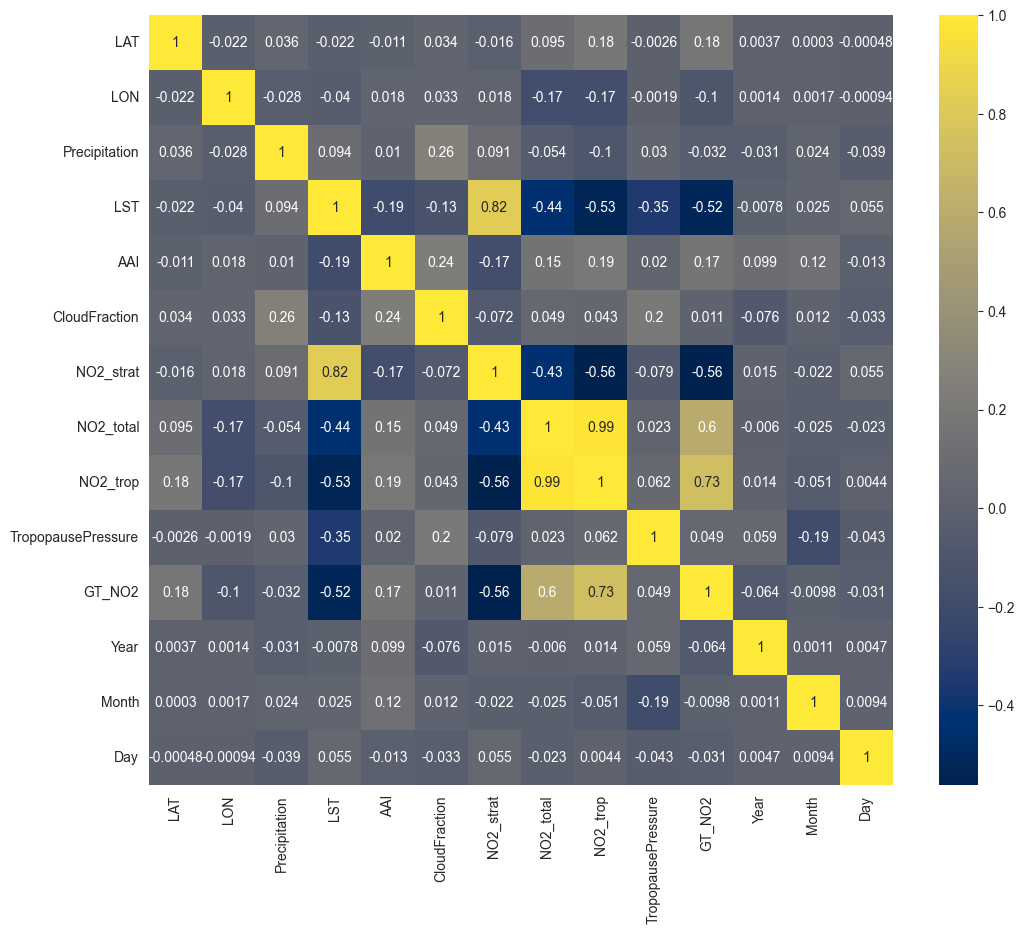

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(train_data.corr(), annot=True, cmap='cividis')